# EXEMPLO DE REGRESSÃO LINEAR

# 0 CARREGAR BIBLIOTECAS

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mplot
import seaborn as sns
import statsmodels.stats.outliers_influence as smstatsout
import statsmodels.api as smapi
import scipy as sp
import patsy as pt
import sklearn as sk
import sklearn.model_selection as skms

In [2]:
# Para permitir gráficos interativos no notebook
%matplotlib notebook

# 1 CARREGAR OS DADOS

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

In [4]:
## Nome das colunas foi adquirido do arquivo aut-mp.names
## https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names
names = ['mpg', 'cyl', 'disp', 'hp', 'weight', 'acc', 'year', 'origin', 'name']

In [5]:
df = pd.read_table(url, header = None, delim_whitespace = True, names = names)

In [6]:
pd.DataFrame.head(df)

,mpg,cyl,disp,hp,weight,acc,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


# 2 EDA

## 2.1 Estatísticas descritivas

In [7]:
df.describe()

,mpg,cyl,disp,weight,acc,year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


Importante notar que as variáveis year e origin parecem ser "fatores". Elas são números, mas não representam ordem de grandeza.

## 2.2 Separação das variáveis

Para facilitar a vizualização e também a modelagem posterior, vamos seprar o dataframe em três pedaços: (1) a respostas, mpg, (2) as variáveis categóricas e (3) as variáveis numéricas.

### 2.2.1 Variáveis categóricas.

Antes de separar as variáveis, vamos transformar tanto o ano quanto a origem em "fatores".

In [8]:
# Variável ano
df['year'] = df['year'].astype('category')

# Variável origem
df['origin'] = df['origin'].astype('category')

# Seleciona somente variáveis categóricas
xCat = df.select_dtypes(include = 'category')

In [9]:
pd.DataFrame.head(xCat)

,year,origin
0,70,1
1,70,1
2,70,1
3,70,1
4,70,1


### 2.2.2 Variáveis numéricas

In [10]:
# Seleciona somente as variáveis numéricas
xNum = df.select_dtypes(include = 'number')

# Remover a coluna de resposta 'mpg'
xNum.drop(['mpg'], axis = 1, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
pd.DataFrame.head(xNum)

,cyl,disp,weight,acc
0,8,307.0,3504.0,12.0
1,8,350.0,3693.0,11.5
2,8,318.0,3436.0,11.0
3,8,304.0,3433.0,12.0
4,8,302.0,3449.0,10.5


### 2.2.3 Resposta

In [12]:
# Salva a resposta no objeto 'y'
y = df['mpg']

In [13]:
pd.DataFrame.head(y)

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64

## 2.3 Distribuição das variáveis

### 2.3.1 Variáveis cagegóricas

<IPython.core.display.Javascript object>


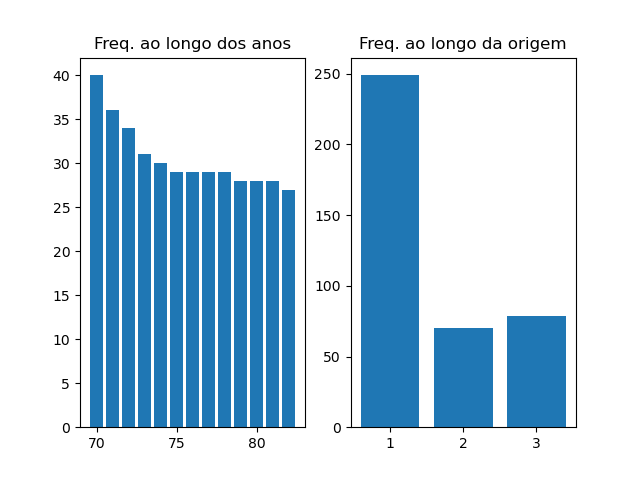

Text(0.5, 1.0, 'Freq. ao longo da origem')

In [14]:
# Cria imagens vazias
fig = mplot.pyplot.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#Gráfico para frequência dos anos
ax1.bar(xCat['year'].unique(), xCat['year'].value_counts())
ax1.set_title('Freq. ao longo dos anos')

# Gráfico para frequência das origens
ax2.bar(xCat['origin'].unique(), xCat['origin'].value_counts())
ax2.set_title('Freq. ao longo da origem')


Percebe-se que a frequência de carros em cada ano ou cada origem não é a mesma. 

### 2.3.2 Variáveis numéricas

<IPython.core.display.Javascript object>


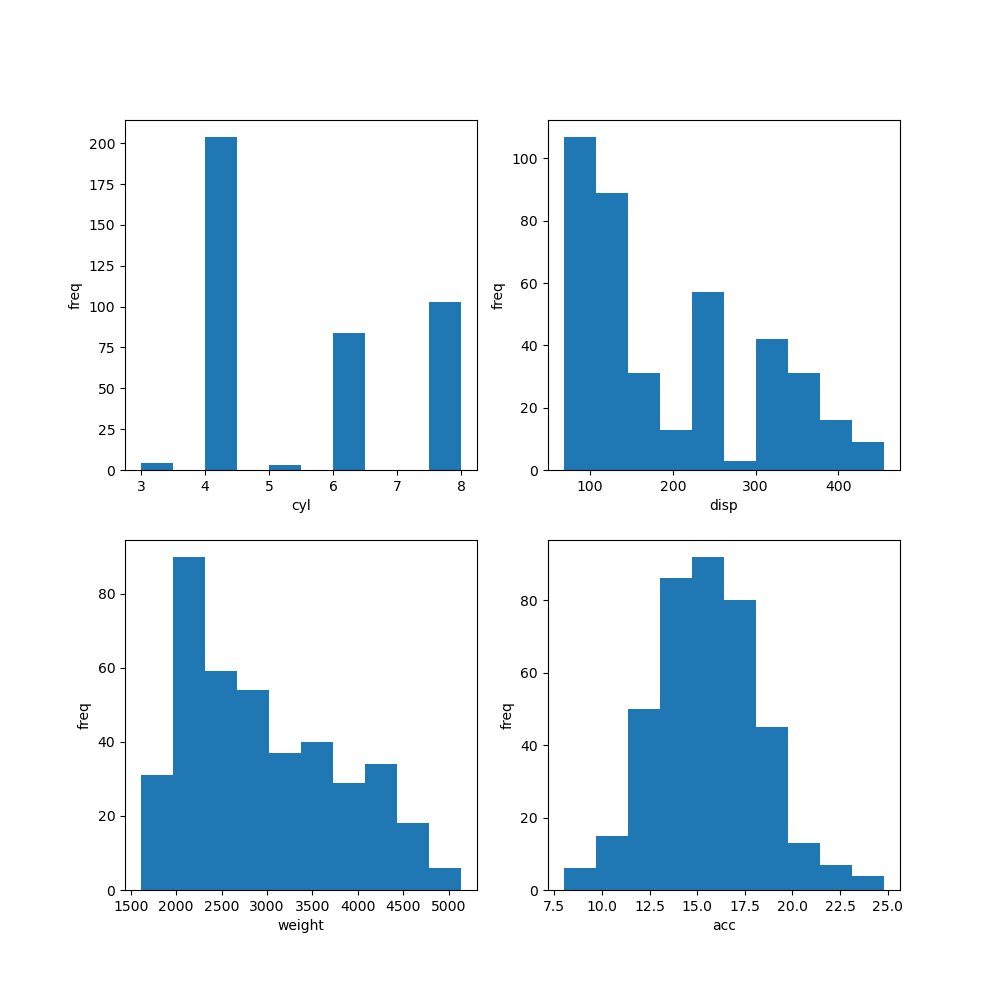

In [15]:
# Definir a quantidade de subplots
nCols = 2
nRows = int(np.ceil(len(xNum.columns) / (1.0*nCols)))

# Plota a figura vazia
fig, axes = mplot.pyplot.subplots(nrows = nRows, ncols = nCols, figsize = (10, 10))

# Inicializa a variáve counter
counter = 0

# Plota os histogramas de modo automático
for i in range(nRows):
    for j in range(nCols):
    
        ax = axes[i][j]
        
        # Plota somente se tivermos dados
        if counter < len(xNum.columns):
            
            ax.hist(xNum[xNum.columns[counter]]) # Plota o gráfico
            ax.set_xlabel(xNum.columns[counter]) # Define o título do eixo x
            ax.set_ylabel('freq')
            
        else:
            ax.set_axis_off()
            
        counter += 1
    
mplot.pyplot.show()


É possível ver que as variáveis contínuas possuem (1) escalas diferentes e (2) distribuições que não são normais. Em alguns casos (como na variávei 'disp') há uma bimodalidade aparente.

### 2.3.3 Resposta

<IPython.core.display.Javascript object>


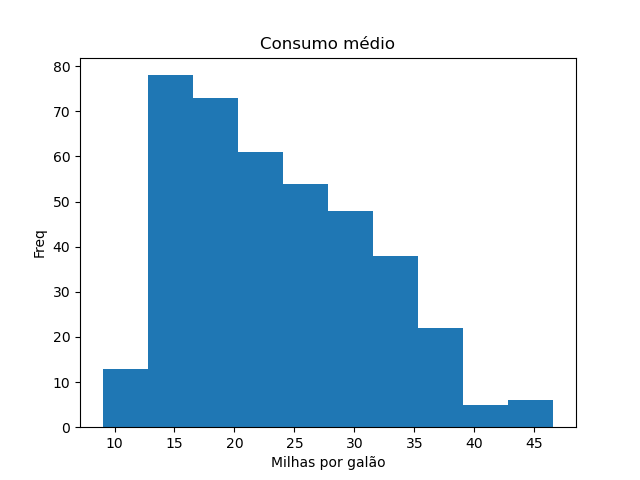

Text(0, 0.5, 'Freq')

In [16]:
fig = mplot.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
mplot.pyplot.hist(y)
ax.set_title('Consumo médio')
ax.set_xlabel('Milhas por galão')
ax.set_ylabel('Freq')

A resposta claramente não possui uma distribuição normal. Ela possui uma grande assimetria para a esquerda.

# 3 PRÉ TRATAMENTO

# 3.1 Resposta

Antes de realizar qualquer transformação na resposta, vamos realizar um teste de normalidade com o intuito de quantificar o desvio.

In [17]:
kStat,kPvalue = sp.stats.kstest(y, 'norm')

In [18]:
kStat

1.0

In [19]:
kPvalue

0.0

Como dito na aula sobre pré tratamento dos dados, um p-value pequeno representa que os dados não são normais. Por isso, é interessante tentar normalizá-los antes da modelagem. Uma transformação muito comum para dados assimétricos é a logarítmo natural, 'ln'. Para que essa transformação seja utilizada, não é permitido existir nenhum número menor ou igual a zero nos dados.

### Transformação da resposta - LN

In [20]:
yLog = np.log(y)

<IPython.core.display.Javascript object>


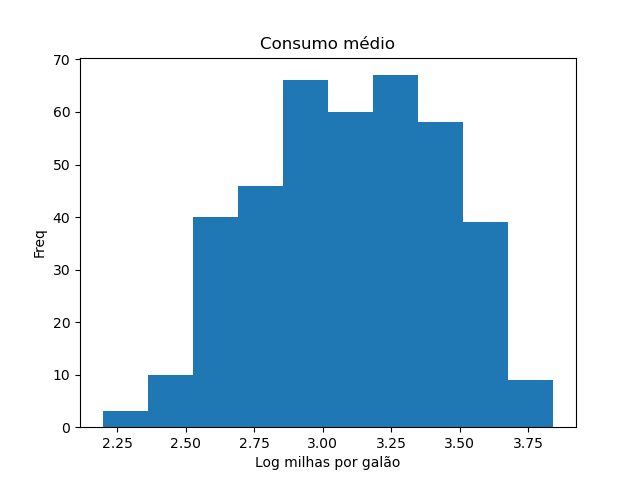

Text(0, 0.5, 'Freq')

In [21]:
fig = mplot.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
mplot.pyplot.hist(yLog)
ax.set_title('Consumo médio')
ax.set_xlabel('Log milhas por galão')
ax.set_ylabel('Freq')

In [22]:
kStat,kPvalue = sp.stats.kstest(yLog, 'norm')

In [23]:
kStat

0.9868363378442295

In [24]:
kPvalue

0.0

Como pode ser visto, apesar de graficamente os dados terem melhorado, o teste de normalidade ainda mostra dados não normais. Por isso, testar-se-á um método mais moderno chamado transformada de Box-Cox, que faz vários tipos de trasnformadas e indica qual é a melhor.

### Transformação da resposta - Box Cox

In [25]:
yBx = sp.stats.boxcox(y, alpha = 0.01)

In [26]:
# Mostra o melhor valor da transformação
yBx[1]

0.19735475361200427

In [27]:
# Mostra o intervalo de confiança 99%
yBx[2]

(-0.18013781883434132, 0.577186423120012)

Com esses resultados, há duas possibilidades: (1) usar o valor do lambda ótimo, de 0.197 e (2) usar um valor aproximado que está dentro do intervalo de confiança. Nesse caso, ambos '0' e '0.5' estão dentro do intervalo. O valor '0' equivale ao logaritmo natural, que já foi testado. Vamos então avaliar o lambda ótimo e o valor de 0.5 (raiz quadrada).

#### Lambda ótimo = 0.197

<IPython.core.display.Javascript object>


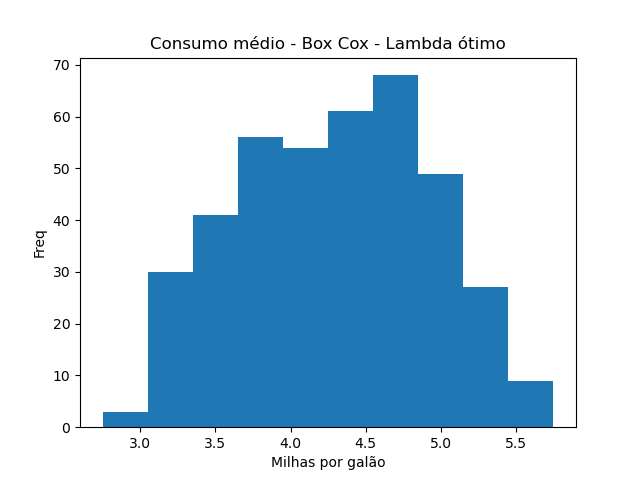

Text(0, 0.5, 'Freq')

In [28]:
fig = mplot.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
mplot.pyplot.hist(yBx[0])
ax.set_title('Consumo médio - Box Cox - Lambda ótimo')
ax.set_xlabel('Milhas por galão')
ax.set_ylabel('Freq')

In [29]:
kStat,kPvalue = sp.stats.kstest(yBx[0], 'norm')

In [30]:
kStat

0.9970260615656921

In [31]:
kPvalue

0.0

#### Lambda de 0.5 (raiz quadrada)

In [32]:
ySqrt = np.sqrt(y)

<IPython.core.display.Javascript object>


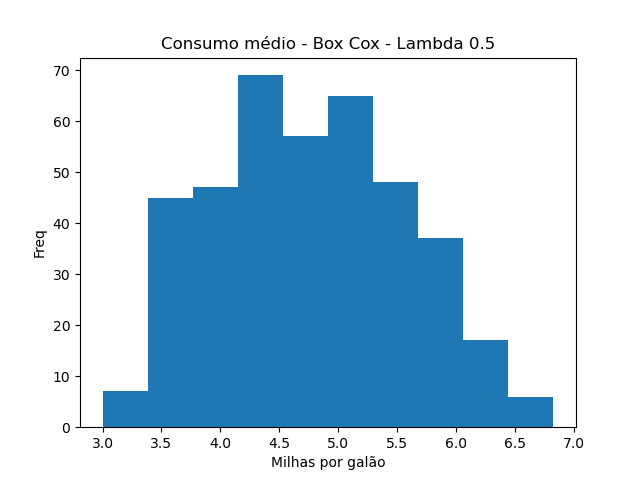

Text(0, 0.5, 'Freq')

In [33]:
fig = mplot.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
mplot.pyplot.hist(ySqrt)
ax.set_title('Consumo médio - Box Cox - Lambda 0.5')
ax.set_xlabel('Milhas por galão')
ax.set_ylabel('Freq')

In [34]:
kStat,kPvalue = sp.stats.kstest(ySqrt, 'norm')

In [35]:
kStat

0.9986501019683699

In [36]:
kPvalue

0.0

Nenhuma transformada foi capaz de normalizar a resposta numericamente, mas é possível pelos gráficos que todas conseguiram pelo menos diminuir a assimetria. Assim, vamos dar seguimento utilizando o logaritmo natural por essas razões: (1) historicamente é a trasnformada mais utilizada, (2) é fácil de "voltar" os dados á escala original (exp(log(y)) e (3) apresentou o menor valor da estatística no teste do Kolmogorov.

## 3.2 Variáveis contínuas

Para as variáveis contínuas, a transformação utilizada será o escalonamento. Para facilitar a aplicação dessa operação, uma função será criada.

In [37]:
def feat_scale(X):
    # Calcula a média de todas as variáveis
    mu = np.mean(X, axis = 0) 
    
    # Calcula o desvio padrão de todas as variáveis
    sigma = np.std(X, axis = 0, ddof = 1) 
    
    # Faz o escalonamento
    xNorm = (X - mu)/sigma
    
    return xNorm, mu, sigma

In [38]:
# Aplicando a função às variáveis contínuas
xNorm, mu, sigma = feat_scale(xNum)

In [39]:
pd.DataFrame.head(xNorm)

,cyl,disp,weight,acc
0,1.496308,1.089233,0.630077,-1.293870
1,1.496308,1.501624,0.853259,-1.475181
2,1.496308,1.194728,0.549778,-1.656492
3,1.496308,1.060461,0.546236,-1.293870
4,1.496308,1.041280,0.565130,-1.837804


Checando o resultado.

<IPython.core.display.Javascript object>


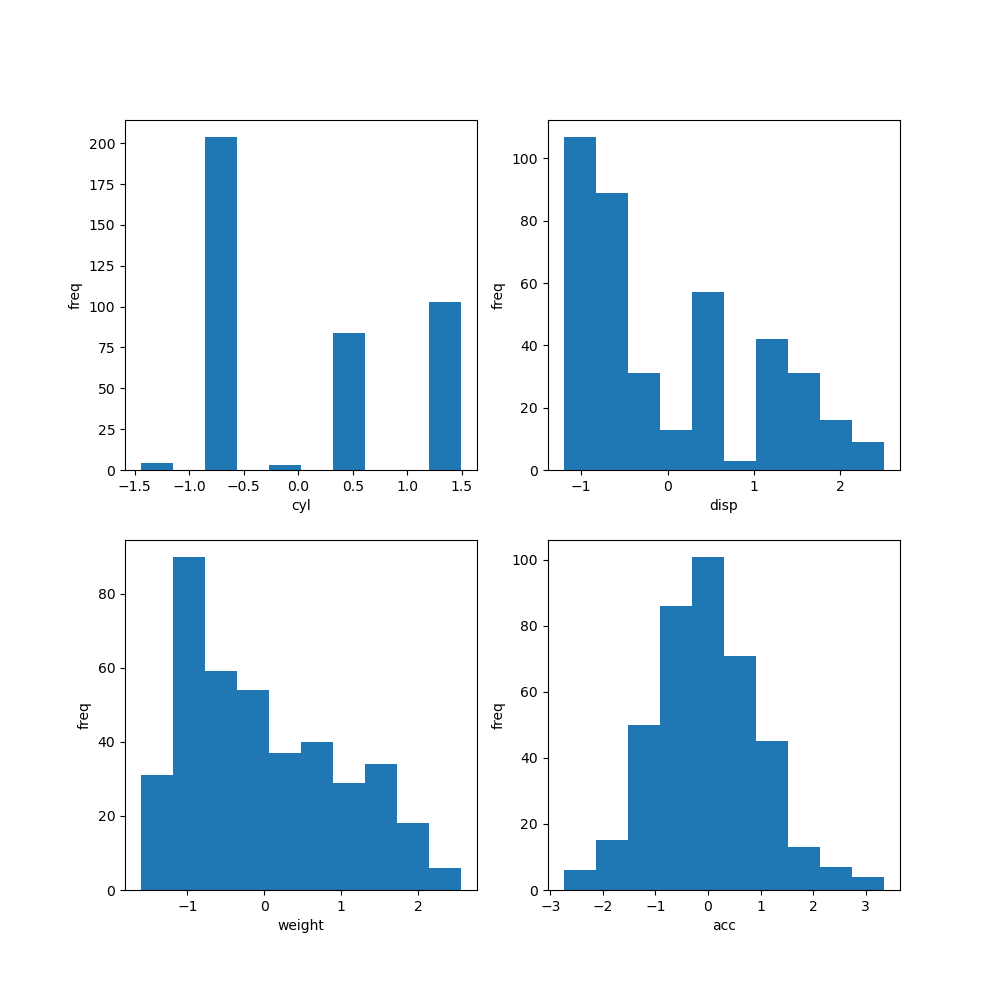

In [40]:
# Definir a quantidade de subplots
nCols = 2
nRows = int(np.ceil(len(xNorm.columns) / (1.0*nCols)))

# Plota a figura vazia
fig, axes = mplot.pyplot.subplots(nrows = nRows, ncols = nCols, figsize = (10, 10))

counter = 0

# Plota os histogramas de modo automático
for i in range(nRows):
    for j in range(nCols):
    
        ax = axes[i][j]
        
        # Plota somente se tivermos dados
        if counter < len(xNum.columns):
            
            ax.hist(xNorm[xNorm.columns[counter]]) # Plota o gráfico
            ax.set_xlabel(xNorm.columns[counter]) # Define o título do eixo x
            ax.set_ylabel('freq')
            
        else:
            ax.set_axis_off()
            
        counter += 1
    
mplot.pyplot.show()


In [41]:
np.mean(xNorm)

cyl      -5.065741e-16
disp     -8.256935e-17
weight   -9.637740e-17
acc       5.479704e-15
dtype: float64

In [42]:
np.std(xNorm, ddof = 1)

cyl       1.0
disp      1.0
weight    1.0
acc       1.0
dtype: float64

Agora todas as variáveis possuem média zero e desvio padrão igual a 1.

#### Avaliação da multicolinearidade

<IPython.core.display.Javascript object>


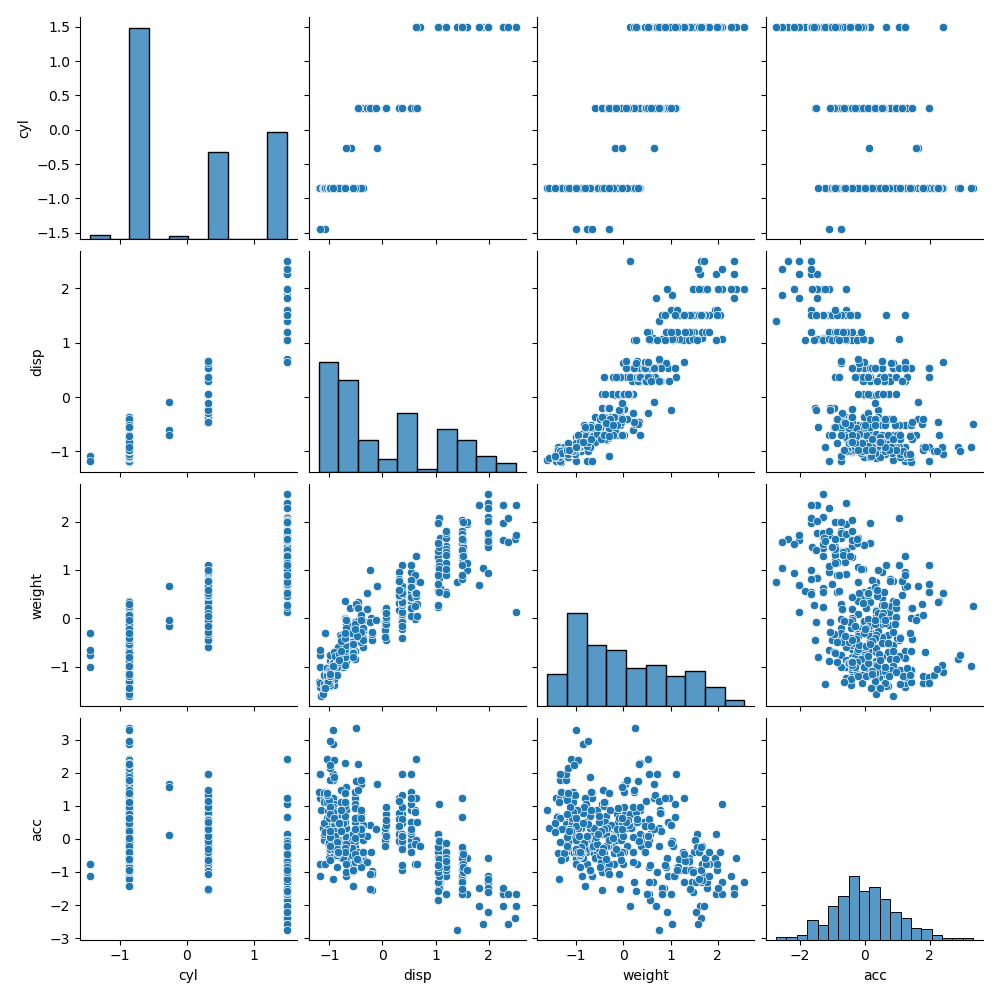

In [43]:
sns.pairplot(xNorm)

Mesmo com a normalização das variáveis, ainda é possível ver uma alta correlação entre peso e deslocamento e deslocamento e aceleração. Deveremos tomar cuidado com os testes estatísticos dessas duas variáveis.

## 3.3 Variáveis categoricas

Para as variáveis categóricas, o pré-processamento consiste em "dummyficar" seus valores.

In [44]:
xCatD = pd.get_dummies(xCat)

In [45]:
pd.DataFrame.head(xCatD)

,year_70,year_71,year_72,year_73,year_74,year_75,year_76,year_77,year_78,year_79,year_80,year_81,year_82,origin_1,origin_2,origin_3
0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


# 4 AJUSTE DO MODELO E SIGNIFICÂNCIA - Y NA ESCALA ORIGINAL

Nesta seção vamos ajustar o modelo somente pelo método dos mínimos qudrados. Mais adiante, faremos o ajuste pelo método do gradiente descendente.

Apenas para efeito didático, vamos ajustar 3 modelos: o primeiro terá somente as variáveis contínuasm, o segundo somente as variáveis discretas. O terceiro modelo terá todas as variáveis disponíveis. Todos serão feitos com a escala original para que posteriormente façamos com a escala logarítimica e vejamos a diferença.

Para os dois modelos iniciais, como há um objetivo apenas pedagógico, os datasets não serão separados entre ajuste e teste. 

Para ajustar o modelo usando a biblioteca Statsmodels, primeiro é necessário criar a matrix de especificação do modelo, usando a bibliote Patsy. Isso exige que se junte o dataframe com os dados dos regressores com os dados da resposta.

## 4.1 Modelo com variáveis contínuas

In [46]:
dfNorm = pd.concat([y.reset_index(drop=True), xNorm], axis=1) # Junta y com xNorm

In [47]:
pd.DataFrame.head(dfNorm)

,mpg,cyl,disp,weight,acc
0,18.0,1.496308,1.089233,0.630077,-1.293870
1,15.0,1.496308,1.501624,0.853259,-1.475181
2,18.0,1.496308,1.194728,0.549778,-1.656492
3,16.0,1.496308,1.060461,0.546236,-1.293870
4,17.0,1.496308,1.041280,0.565130,-1.837804


Para a construção da fórmula usando o Patsy, o modelo inteiro deve ser especificado explicitamente. Para pequenos modelos, essa atividade não gera problemas. Porém, para modelos muito grandes essa atividade pode ser tediosa e até passível de erros. Dessa forma, sugere-se a construção de uma função para "montar" a fórmula

In [48]:
def ols_formula(df, dependent_var, *excluded_cols):
    # Lista o nome das colunas no dataframe
    df_columns = list(df.columns.values)
    
    # Remove a variável dependente
    df_columns.remove(dependent_var)
    
    # Remove as colunas "excluídas" (se houver)
    for col in excluded_cols:
        df_columns.remove(col)
    
    return dependent_var + ' ~ ' + ' + '.join(df_columns)

In [49]:
ols_formula(dfNorm, 'mpg')

'mpg ~ cyl + disp + weight + acc'

In [50]:
y, X = pt.dmatrices(ols_formula(dfNorm, 'mpg'), data=dfNorm, return_type='dataframe')

In [51]:
pd.DataFrame.head(X)

,Intercept,cyl,disp,weight,acc
0,1.0,1.496308,1.089233,0.630077,-1.293870
1,1.0,1.496308,1.501624,0.853259,-1.475181
2,1.0,1.496308,1.194728,0.549778,-1.656492
3,1.0,1.496308,1.060461,0.546236,-1.293870
4,1.0,1.496308,1.041280,0.565130,-1.837804


Percebam que foi adicionado uma coluna de "intercept" no dataframe.

In [52]:
regNorm = smapi.regression.linear_model.OLS(y, X) # Especifica o modelo
resNorm = regNorm.fit() # Ajusta o modelo
print(resNorm.summary()) # Imprime o resultado do modelo

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     230.0
Date:                Wed, 19 May 2021   Prob (F-statistic):          1.58e-101
Time:                        17:47:26   Log-Likelihood:                -1142.5
No. Observations:                 398   AIC:                             2295.
Df Residuals:                     393   BIC:                             2315.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.5146      0.215    109.154      0.0

Como todas as variáveis estão 'escalonadas', é possível fazer uma comparação direta entre os 'coef', que são os 'betas' do modelo. A coluna P>|t| indica os p-values da significância, onde ve-se uma forte influência do peso e da aceleração. Porém, como foi visto a presença de multicolinearidade, é necessário avaliar o quanto ela está afetando o modelo. Um modo de fazer isso é calcular os fatores de inflação da variância (VIF).

In [53]:
pd.DataFrame({'variables': X.columns[1:], 
              'VIF': [smstatsout.variance_inflation_factor(X.values, i+1) for i in range(len(X.columns[1:]))]})

,variables,VIF
0,cyl,10.477644
1,disp,18.281251
2,weight,8.489141
3,acc,1.557257


Valores maiores que '5' devem ser evitados. Dessa maneira, recomenda-se removendo as variáveis de maior VIF. O modelo será refeito sem a variável 'disp'.

In [54]:
y, X2 = pt.dmatrices(ols_formula(dfNorm, 'mpg', 'disp'), data=dfNorm, return_type='dataframe')

In [55]:
pd.DataFrame.head(X2)

,Intercept,cyl,weight,acc
0,1.0,1.496308,0.630077,-1.293870
1,1.0,1.496308,0.853259,-1.475181
2,1.0,1.496308,0.549778,-1.656492
3,1.0,1.496308,0.546236,-1.293870
4,1.0,1.496308,0.565130,-1.837804


In [56]:
regNorm2 = smapi.regression.linear_model.OLS(y, X2) # Especifica o modelo
resNorm2 = regNorm2.fit() # Ajusta o modelo
print(resNorm2.summary()) # Imprime o resultado

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     306.7
Date:                Wed, 19 May 2021   Prob (F-statistic):          1.14e-102
Time:                        17:47:26   Log-Likelihood:                -1142.9
No. Observations:                 398   AIC:                             2294.
Df Residuals:                     394   BIC:                             2310.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.5146      0.215    109.203      0.0

Sem a variável 'disp' é possível ver que a variável 'cyl' começa a ter uma possível significância.

In [57]:
pd.DataFrame({'variables': X2.columns[1:], 
              'VIF': [smstatsout.variance_inflation_factor(X2.values, i+1) for i in range(len(X2.columns[1:]))]})

,variables,VIF
0,cyl,5.673654
1,weight,5.115871
2,acc,1.354660


Sem a variável 'disp', todos os valores de VIF ficam perto de limites aceitáveis.

## 4.2 Modelo com variáveis categóricas "dummy"

In [58]:
dfCat = pd.concat([y.reset_index(drop=True), xCatD], axis=1) # Junta y com xNorm

In [59]:
pd.DataFrame.head(dfCat)

,mpg,year_70,year_71,year_72,year_73,year_74,year_75,year_76,year_77,year_78,year_79,year_80,year_81,year_82,origin_1,origin_2,origin_3
0,18.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,15.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,18.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,16.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,17.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [60]:
y, X = pt.dmatrices(ols_formula(dfCat, 'mpg'), data=dfCat, return_type='dataframe')

In [61]:
pd.DataFrame.head(X)

,Intercept,year_70,year_71,year_72,year_73,year_74,year_75,year_76,year_77,year_78,year_79,year_80,year_81,year_82,origin_1,origin_2,origin_3
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [62]:
regCat = smapi.regression.linear_model.OLS(y, X) # Especifica o modelo
resCat = regCat.fit() # Ajusta o modelo
print(resCat.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     48.06
Date:                Wed, 19 May 2021   Prob (F-statistic):           2.40e-75
Time:                        17:47:26   Log-Likelihood:                -1180.8
No. Observations:                 398   AIC:                             2392.
Df Residuals:                     383   BIC:                             2451.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.3442      0.202     90.924      0.0

Aqui, cada 'coef' significa o aumento ou redução da média geral 'intercepet' quando um ano específico ou uma origem específica é escolhida.

## 4.3 Modelo com todas as variáveis

Antes de fazer o modelo com todas as variáveis, é necessário juntar todos os datasets. Como esse será o modelo final, vamos dividir o dataset em ajuste e teste, para que as métricas de qualidade de ajuste sejam calculadas somente nos dados de teste.

### 4.3.1 Concatenar datasets

In [63]:
dfFinal = pd.concat([dfNorm.reset_index(drop=True), xCatD], axis=1)

In [64]:
pd.DataFrame.head(dfFinal)

,mpg,cyl,disp,weight,acc,year_70,year_71,year_72,year_73,year_74,...,year_76,year_77,year_78,year_79,year_80,year_81,year_82,origin_1,origin_2,origin_3
0,18.0,1.496308,1.089233,0.630077,-1.293870,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,15.0,1.496308,1.501624,0.853259,-1.475181,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,18.0,1.496308,1.194728,0.549778,-1.656492,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,16.0,1.496308,1.060461,0.546236,-1.293870,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,17.0,1.496308,1.041280,0.565130,-1.837804,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Formar matrix do modelo.

In [65]:
y, X = pt.dmatrices(ols_formula(dfFinal, 'mpg', 'disp'), data = dfFinal, return_type='dataframe')

In [66]:
pd.DataFrame.head(X)

,Intercept,cyl,weight,acc,year_70,year_71,year_72,year_73,year_74,year_75,year_76,year_77,year_78,year_79,year_80,year_81,year_82,origin_1,origin_2,origin_3
0,1.0,1.496308,0.630077,-1.293870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,1.496308,0.853259,-1.475181,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.496308,0.549778,-1.656492,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.496308,0.546236,-1.293870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.496308,0.565130,-1.837804,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [67]:
pd.DataFrame.head(y)

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


### 4.3.2 Dividir datasets

In [68]:
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.2, random_state=0)

In [69]:
# Reset all dataframes index
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### 4.3.3 Ajustar modelo

In [70]:
regFinal = smapi.regression.linear_model.OLS(y_train, X_train) # Especifica o modelo
resFinal = regFinal.fit() # Ajusta o modelo
print(resFinal.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     100.5
Date:                Wed, 19 May 2021   Prob (F-statistic):          7.71e-113
Time:                        17:47:27   Log-Likelihood:                -800.68
No. Observations:                 318   AIC:                             1637.
Df Residuals:                     300   BIC:                             1705.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.1490      0.156    109.686      0.0

Check de VIF final do modelo.

In [71]:
pd.DataFrame({'variables': X_train.columns[1:], 
              'VIF': [smstatsout.variance_inflation_factor(X_train.values, i+1) for i in range(len(X_train.columns[1:]))]})

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,cyl,6.235065
1,weight,5.456322
2,acc,1.451069
3,year_70,inf
4,year_71,inf
5,year_72,inf
6,year_73,inf
7,year_74,inf
8,year_75,inf
9,year_76,inf


### 4.4 Avaliação da qualidade de ajuste

In [72]:
# Predict the values using dados de teste
pd.DataFrame.head(resFinal.predict(X_test))

0    13.458026
1    23.127015
2    13.051024
3    22.078209
4    18.974951
dtype: float64

In [73]:
predY = pd.concat([y_test, resFinal.predict(X_test)], axis=1)
predY.columns = ['mpgReal', 'mpgPrev']

In [74]:
pd.DataFrame.head(predY)

,mpgReal,mpgPrev
0,14.0,13.458026
1,25.0,23.127015
2,13.0,13.051024
3,21.0,22.078209
4,18.0,18.974951


In [75]:
print('Rquadrado:', sk.metrics.r2_score(predY['mpgReal'], predY['mpgPrev']))
print('Raiz do erro quadrado médio:', np.sqrt(sk.metrics.mean_squared_error(predY['mpgReal'], predY['mpgPrev'])))

Rquadrado: 0.8389953210238432
Raiz do erro quadrado médio: 3.1963939510868493


# 5 ANÁLISE DE RESÍDUOS - Y NA ESCALA ORIGINAL

Para analisar os resíduos, primeiro precisa-se calcular os resíduos.

## 5.1 Cálculo dos resíduos

In [76]:
predY['res'] = predY['mpgReal'] - predY['mpgPrev']

In [77]:
pd.DataFrame.head(predY)

,mpgReal,mpgPrev,res
0,14.0,13.458026,0.541974
1,25.0,23.127015,1.872985
2,13.0,13.051024,-0.051024
3,21.0,22.078209,-1.078209
4,18.0,18.974951,-0.974951


## 5.2 Normalidade

<IPython.core.display.Javascript object>


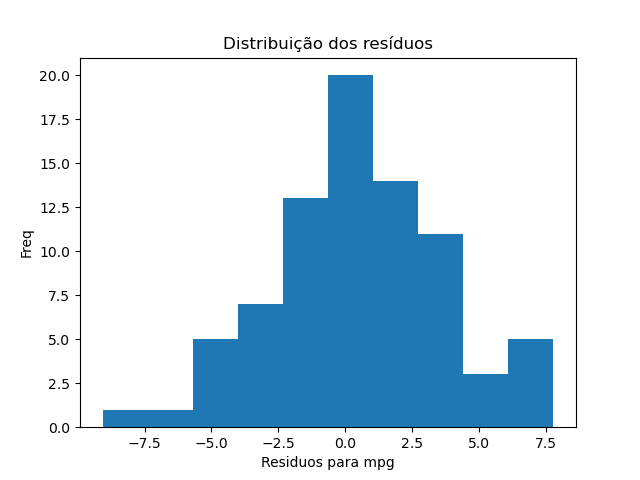

Text(0, 0.5, 'Freq')

In [78]:
fig = mplot.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
mplot.pyplot.hist(predY['res'])
ax.set_title('Distribuição dos resíduos')
ax.set_xlabel('Residuos para mpg')
ax.set_ylabel('Freq')

In [79]:
kStat,kPvalue = sp.stats.kstest(predY['res'], 'norm')

In [80]:
kStat

0.35233123676133826

In [81]:
kPvalue

2.1866836056340633e-09

## 5.3 Homocedasticidade

<IPython.core.display.Javascript object>


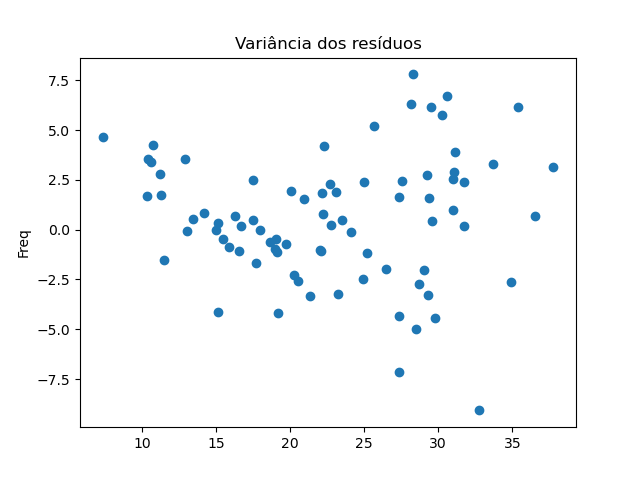

Text(0, 0.5, 'Freq')

In [82]:
fig = mplot.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
mplot.pyplot.scatter(predY['mpgPrev'], predY['res'])
ax.set_title('Variância dos resíduos')
ax.set_xlabel('')
ax.set_ylabel('Freq')

Como a variável a variável Y foi utilizada em seus valor original, os resíduos apresentam um pouco de heteroscedastidade e também falharam no teste de normalidade. Vamos repetir o modelo com o logaritmo para ver os efeitos.

# 6 MODELO COM O LN(Y)

## 6.1 Modelo

In [83]:
regLog = smapi.regression.linear_model.OLS(np.log(y_train), X_train) # Especifica o modelo - tira o log da resposta
resFinLog = regLog.fit() # Ajusta o modelo
print(resFinLog.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     150.1
Date:                Wed, 19 May 2021   Prob (F-statistic):          1.62e-135
Time:                        17:47:27   Log-Likelihood:                 252.96
No. Observations:                 318   AIC:                            -469.9
Df Residuals:                     300   BIC:                            -402.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2133      0.006    388.963      0.0

## 6.2 Métricas de qualidade de ajuste

In [84]:
# Usando o modelo resFinLog
predYLog = pd.concat([y_test, np.exp(resFinLog.predict(X_test))], axis=1)
predYLog.columns = ['mpgReal', 'mpgPrev']

In [85]:
pd.DataFrame.head(predYLog)

,mpgReal,mpgPrev
0,14.0,13.845203
1,25.0,23.095121
2,13.0,13.504346
3,21.0,21.018789
4,18.0,18.361161


In [86]:
print('Rquadrado:', sk.metrics.r2_score(predYLog['mpgReal'], predYLog['mpgPrev']))
print('Raiz do erro quadrado médio:', np.sqrt(sk.metrics.mean_squared_error(predYLog['mpgReal'], predYLog['mpgPrev'])))

Rquadrado: 0.8814501952077259
Raiz do erro quadrado médio: 2.74278315199728


## 6.3 Análise residual

In [87]:
predYLog['res'] = predYLog['mpgReal'] - predYLog['mpgPrev']

In [88]:
pd.DataFrame.head(predYLog)

,mpgReal,mpgPrev,res
0,14.0,13.845203,0.154797
1,25.0,23.095121,1.904879
2,13.0,13.504346,-0.504346
3,21.0,21.018789,-0.018789
4,18.0,18.361161,-0.361161


### Normalidade

<IPython.core.display.Javascript object>


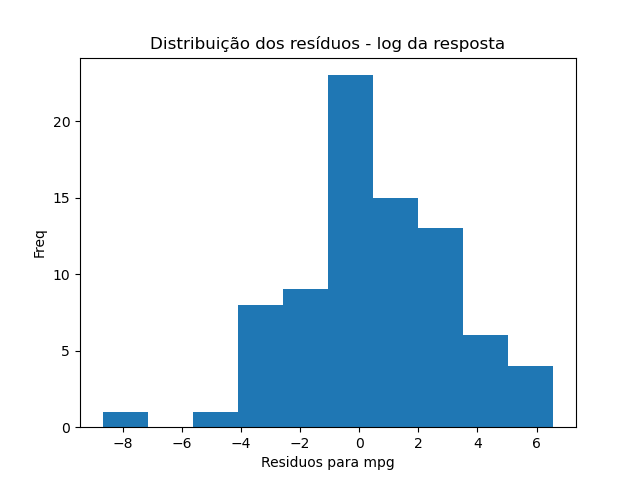

Text(0, 0.5, 'Freq')

In [89]:
fig = mplot.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
mplot.pyplot.hist(predYLog['res'])
ax.set_title('Distribuição dos resíduos - log da resposta')
ax.set_xlabel('Residuos para mpg')
ax.set_ylabel('Freq')

In [90]:
kStat,kPvalue = sp.stats.kstest(predYLog['res'], 'norm')

In [91]:
kStat

0.2995963099953317

In [92]:
kPvalue

7.28507678445783e-07

### Homocedasticidade

<IPython.core.display.Javascript object>


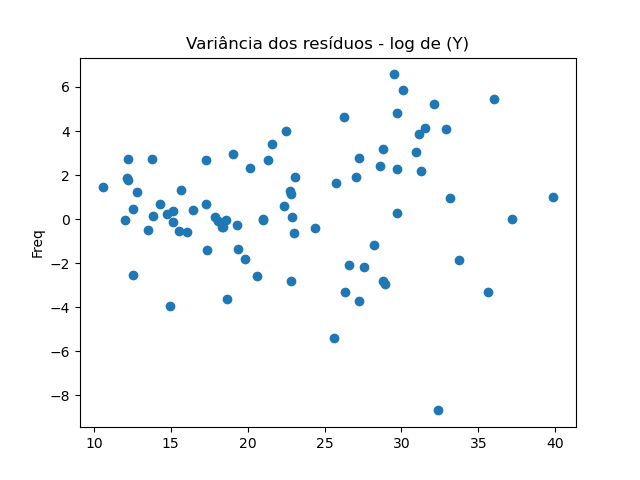

Text(0, 0.5, 'Freq')

In [93]:
fig =  mplot.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
mplot.pyplot.scatter(predYLog['mpgPrev'], predYLog['res'])
ax.set_title('Variância dos resíduos - log de (Y)')
ax.set_xlabel('')
ax.set_ylabel('Freq')

Mesmo tirando o log e o modelo tendo melhores métricas de qualidade de previsão, a análise residual, apesar de estar melhor, ainda mostra alguns problemas. Provavelmente o modelo mais complexo, com interações ou alguma não linearidade, poderia ajudar a resolver o problema.

# 7 AJUSTE POR GRADIENTE DESCENDENTE

## 7.1 Função perda

In [94]:
def funcao_perda(X, y, theta):
  
  """
  X é a matrix com os regressores (m x n).
  y é a série com a resposta (1 x m).
  theta é a série com os parâmetros (1 x n)
  """
  
  #np.dot realiza uma multiplicação de matrizes
  pred = X.dot(theta)
  
  #Cálculo dos resíduos para o conjunto de thetas
  res = np.subtract(pred, y.squeeze())
  
  #Calcula o quadrado dos erros 
  sqrRes = np.square(res)
  
  #Calculo da perda 
  perda = 1 / (2 * m) * np.sum(sqrRes)
  
  return perda

## 7.2 Função gradiente descendente

In [95]:
def gradiente_descendente(X, y, theta, alpha, itera):
  """
  Argumentos de entrada
  
  X é a matriz dos regressores (m x n).
  y é a série da resposta (1 x m).
  theta é a série dos valores dos parâmetros (1 x n).
  alpha é a taxa de aprendizado (esccalar).
  itera é q quantidade de iterações do método (escalar)
  
  Resultados
  -----------------
  theta é o valor final dos parâmetros
  hist_perda é o valor da perda ao longo da iterações
  """
  # Inicializa a série do histórico de perdas
  hist_perda = np.zeros(itera)

  for i in range(itera):
    # Calcula as previsões com os atuais valores dos parâmetros
    pred = X.dot(theta)
   
    # Calcula os resíduos das previsões
    res = np.subtract(pred, y.squeeze())
    
    # Calcula o próximo valor dos thetas - derivada parcial da função perda
    sum_delta = (alpha / m) * X.transpose().dot(res);
    
    # Atualiza os valores de theta    
    theta = theta - sum_delta;
    
    # Calcula o valor da perda com os novos valores de theta
    hist_perda[i] = funcao_perda(X, y, theta)  

  return theta, hist_perda

## 7.3 Aplicação

Antes de aplicar o gradiente descendente, deve-se definir o falor de "alpha" e a quantidade de iterações do método.

In [96]:
# Salva o tamanho do df com os regressores (incluindo o )
m, n = X_train.shape

# Inicializa os valores de "theta"
theta = np.zeros(n)

# Iterações
itera = 1000

# Taxa de aprendizado
alpha = 0.3

In [97]:
# Roda o algoritmo de gradiente descendente para os dados de teste
theta, hist_perda = gradiente_descendente(X = X_train, y = np.log(y_train), theta = theta, alpha = alpha, itera = itera)

In [98]:
theta

Intercept    2.213303
cyl          0.005835
weight      -0.231080
acc          0.018474
year_70      0.001945
year_71      0.089290
year_72      0.046365
year_73      0.010420
year_74      0.111923
year_75      0.107325
year_76      0.114482
year_77      0.193609
year_78      0.172580
year_79      0.269875
year_80      0.389557
year_81      0.348536
year_82      0.357397
origin_1     0.692888
origin_2     0.766739
origin_3     0.753677
dtype: float64

### Convergência

<IPython.core.display.Javascript object>


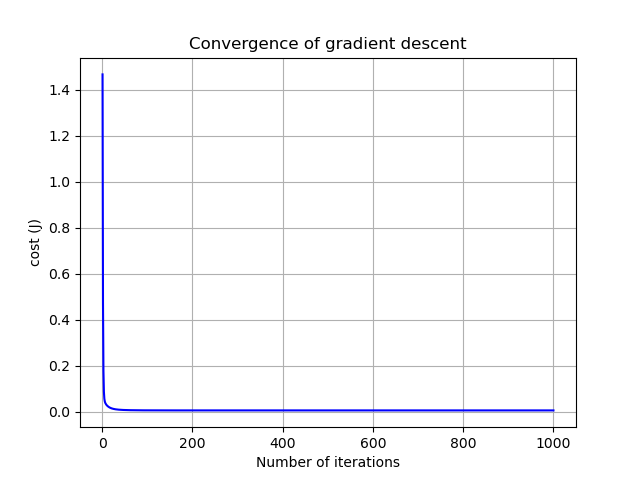

Text(0.5, 1.0, 'Convergence of gradient descent')

In [99]:
fig =  mplot.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
mplot.pyplot.plot(range(1, itera +1), hist_perda, color ='blue')
mplot.pyplot.rcParams["figure.figsize"] = (10,6)
mplot.pyplot.grid()
mplot.pyplot.xlabel("Number of iterations")
mplot.pyplot.ylabel("cost (J)")
mplot.pyplot.title("Convergence of gradient descent")

### Previsão dos valores e resíduos

In [100]:
pd.DataFrame.head(np.exp(X_test.dot(theta)))

0    13.845203
1    23.095122
2    13.504346
3    21.018789
4    18.361161
dtype: float64

In [101]:
predGradYLog = pd.concat([y_test, np.exp(X_test.dot(theta))], axis=1)
predGradYLog.columns = ['mpgReal', 'mpgPrev']
predGradYLog['res'] = predGradYLog['mpgReal'] - predGradYLog['mpgPrev']

In [102]:
pd.DataFrame.head(predGradYLog)

,mpgReal,mpgPrev,res
0,14.0,13.845203,0.154797
1,25.0,23.095122,1.904878
2,13.0,13.504346,-0.504346
3,21.0,21.018789,-0.018789
4,18.0,18.361161,-0.361161


### Métricas de qualidade

In [103]:
print('Rquadrado:', sk.metrics.r2_score(predGradYLog['mpgReal'], predGradYLog['mpgPrev']))
print('Raiz do erro quadrado médio:', np.sqrt(sk.metrics.mean_squared_error(predGradYLog['mpgReal'], predGradYLog['mpgPrev'])))

Rquadrado: 0.8814502079540414
Raiz do erro quadrado médio: 2.7427830045471


# 8 REGRESSÃO REGULARIZADA

## 8.1 Regressão Ridge